# Active Learning Demo

#### This work is based on Yu, Kai, Jinbo Bi, and Volker Tresp. "Active learning via transductive experimental design." Proceedings of the 23rd international conference on Machine learning. ACM, 2006.

#### The molecule database QM7b is based on the work of Montavon, Grégoire, et al. "Machine learning of molecular electronic properties in chemical compound space." New Journal of Physics 15.9 (2013): 095003.
#### Data set accessed on 15th October 2018 at https://qmml.org/datasets.html (see GDB7-13 (QM7b)) 


In [42]:
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.mixture import GaussianMixture
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.kernel_ridge import KernelRidge 

## Data Generation

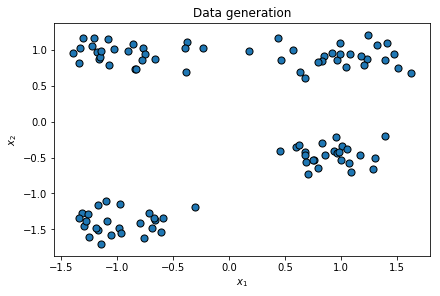

In [43]:
np.random.seed(0)

n_data_points = 100
n_data_points_per_cluster = 25
cov = [[0.1,0],[0,0.1]]
X = np.vstack(( np.random.multivariate_normal([2,5], cov, n_data_points_per_cluster),
      np.random.multivariate_normal([2,2], cov, n_data_points_per_cluster),
      np.random.multivariate_normal([0,5], cov, n_data_points_per_cluster),
      np.random.multivariate_normal([0,0], cov, n_data_points_per_cluster) ))
X = sklearn.preprocessing.scale(X)

fig, ax = plt.subplots(constrained_layout=True)
plt.title("Data generation")
plt.scatter(X[:,0], X[:,1], s=50, edgecolor='k')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

## Sequential Design
#### Let $X$ be the data set, then $K_{ij} = k(X_i,X_j)$ is the corresponding kernel matrix. The sequential design does the following steps to select one data point:
#### 1. Select $x$ with highest $\|K_x\|^2/(k(x,x)+\mu)$, where $K_x$ is the column in $K$ containg $k(x_i,x)$ for all $i$. Additional $\mu$ is a regularization hyperparameter to not divide by zero
#### 2. Update Kernel $K \leftarrow K - \frac{K_xK_x^T}{k(x,x)+\mu}$
#### We will now apply this technique with an RBF kernel

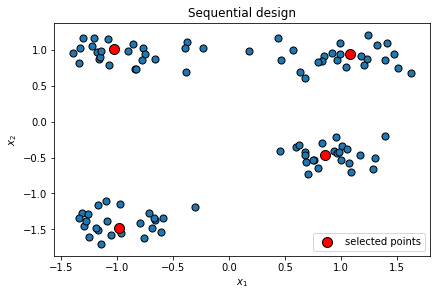

In [44]:
def sequential_design(K, n_points, mu=0.01):
    selected_points = []
    mu = 0.01
    for l in range(n_points):
        val = []
        for i in range(K.shape[0]):
            val.append( np.linalg.norm(K[i])**2/(K[i,i]+mu) )
        best_value_index = np.argmax(val)
        selected_points.append(best_value_index)
        K = K - K[best_value_index][:,np.newaxis].dot(K[best_value_index][np.newaxis,:])/(K[best_value_index,best_value_index]+mu)
    return selected_points

K = rbf_kernel(X,X,1.3)
sequential_design(K,4)
    
fig, ax = plt.subplots(constrained_layout=True)
plt.title("Sequential design")
plt.scatter(X[:,0], X[:,1], s=50, edgecolor='k')
plt.scatter(X[selected_points,0], X[selected_points,1], color='r', s=100, edgecolor='k', label='selected points')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()
plt.show()

## Next we apply this on the QM7b data set with SOAP kernels.

#### The Kernel data was precalculated using Glosim (https://github.com/cosmo-epfl/glosim). We use only 55 data points for demonstration purpose.

In [45]:
Km = np.loadtxt('./QM7b/dsgdb7njp_small_55-n8-l6-c5.0-g0.5_match.k', skiprows=1)
labels = np.loadtxt('./QM7b/dsgdb7njp_atomic_energy_small_55.xyz')

#### We split the data set randomly in 40 training points and 15 test points. We use a normale Kernel Ridge Regression. We compare this model with a random selection and a selection by the sequential design of 10 data points from the training set. The compute the mean absolute error for predictions on the test set and the complete training set.

In [46]:
np.random.seed(1)
indices = np.arange(55)
np.random.shuffle(indices)
train_indices = indices[:40]
test_indices = indices[40:]

def fit_and_predict(train_indices, test_indices, verbose=True):
    alpha = 0.5
    Km_train = Km[train_indices][:, train_indices]
    train_labels = labels[train_indices]
    test_labels = labels[test_indices]
    clf = KernelRidge(alpha=alpha, kernel='precomputed')
    clf.fit(Km_train, train_labels)
    #test_data_kernel_space = sklearn.metrics.pairwise.rbf_kernel(test_data[:,np.newaxis],Xm[:,np.newaxis], gamma) # mapping to kernel space
    test_data_kernel_space = Km[test_indices][:, train_indices]
    test_data_prediction = clf.predict(test_data_kernel_space)
    mae = np.mean(np.abs(test_data_prediction - test_labels))
    if verbose:
        print('MAE',mae)        
    #print('RMSE',np.sqrt(np.mean((test_data_prediction - test_labels)**2)))
    return mae

print('Training set size 40, test set size 15')
fit_and_predict(train_indices, test_indices)

## Randomly selecting 10 data points
random_choice = np.arange(len(train_indices))
np.random.shuffle(random_choice)
random_choice = random_choice[:10]
uniform_selected_train_indices = train_indices[random_choice]

print('Randomly selected 10 data points from training set, tested on test set')
fit_and_predict(uniform_selected_train_indices, test_indices)
print('Randomly selected 10 data points from training set, testet on train set')
fit_and_predict(uniform_selected_train_indices, train_indices)

## Sequential design
K = Km[train_indices][:, train_indices]
sequential_selected_train_indices = train_indices[sequential_design(K,10)]

print('Sequential optimizer selected 10 data points from training set, tested on test set')
fit_and_predict(sequential_selected_train_indices, test_indices)
print('Sequential optimizer selected 10 data points from training set, tested on train set')
fit_and_predict(sequential_selected_train_indices, train_indices)

Training set size 40, test set size 15
MAE 61.870870513475076
Randomly selected 10 data points from training set, tested on test set
MAE 109.5853305192412
Randomly selected 10 data points from training set, testet on train set
MAE 107.57485468951158
Sequential optimizer selected 10 data points from training set, tested on test set
MAE 96.30082437931706
Sequential optimizer selected 10 data points from training set, tested on train set
MAE 100.27024448206112


100.27024448206112

#### We evaluate this truely by running this on 100 randomly splittings of training and test set, predictions are rated on the test set

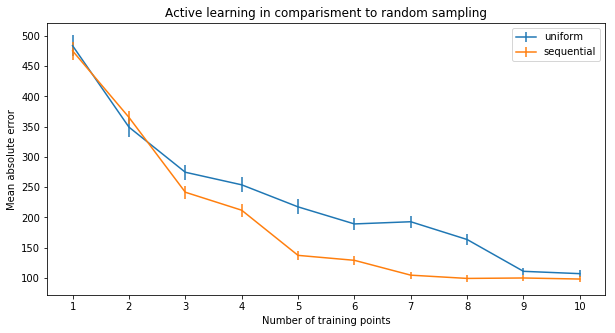

In [47]:
n_trials = 100
n_selection = 10
uniform_selection_trials = np.zeros((n_trials,n_selection))
sequential_selection_trials = np.zeros((n_trials,n_selection))
for t in range(n_trials):    
    indices = np.arange(55)
    np.random.shuffle(indices)
    train_indices = indices[:40]
    test_indices = indices[40:]
    for l in range(n_selection):
        uniform_selection_trials[t][l] = fit_and_predict(uniform_selected_train_indices[:l+1], train_indices, verbose = False)
        sequential_selection_trials[t][l] = fit_and_predict(sequential_selected_train_indices[:l+1], train_indices, verbose = False)

x = np.arange(1,11)
plt.figure(figsize=(10,5))
plt.errorbar(x, np.mean(uniform_selection_trials, axis=0), yerr=np.std(uniform_selection_trials, axis=0), label='uniform')
plt.errorbar(x, np.mean(sequential_selection_trials, axis=0), yerr=np.std(sequential_selection_trials, axis=0), label='sequential')
plt.xticks(x)
plt.title('Active learning in comparisment to random sampling')
plt.xlabel('Number of training points')
plt.ylabel('Mean absolute error')
plt.legend()
plt.show()